In [97]:
import pandas as pd
from math import pi, sin, cos, exp, tan, acos, isclose

 
import numpy as np
import re
from itertools import groupby
from os import listdir, path
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import calendar
from prov.model import ProvDocument
import datetime
from prov.dot import prov_to_dot
from IPython.display import Image


In [98]:
pi = 3.1412

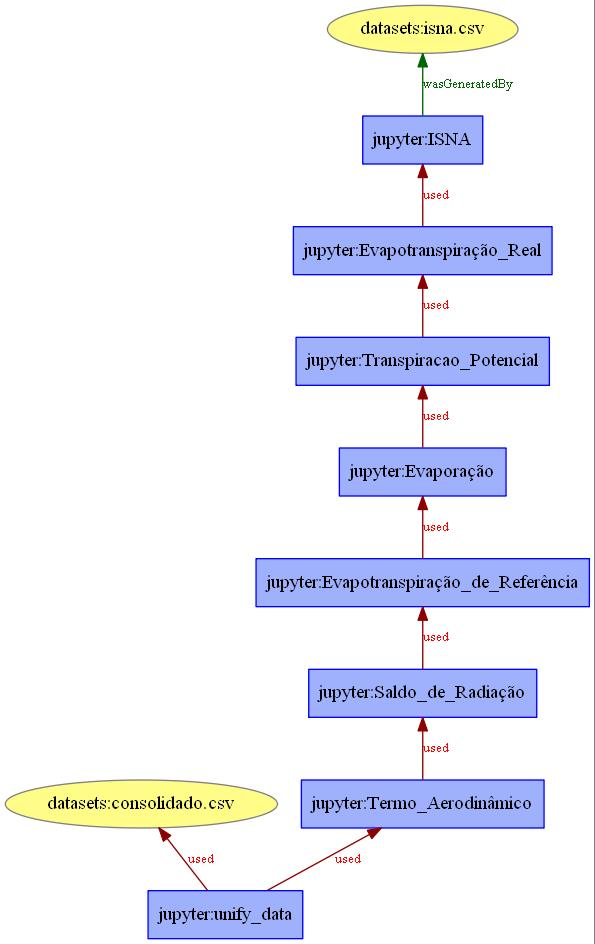

In [99]:
d1 = ProvDocument()

# Declaring namespaces for various prefixes used in the excution of Randon Walk Experiment
d1.add_namespace('inmet', 'datasets/consolidados.csv')
d1.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')
d1.add_namespace('datasets', 'datasets/')
d1.add_namespace('jupyter', 'KcDual-py.ipynb')
d1.add_namespace('local', 'zip')

# Adding an Agent 
#agent = 'foaf:AlexSantoss'
#d1.agent(agent)

# Adding an entity
entity = 'datasets:consolidado.csv'
e1 = d1.entity(entity)
 
entity = 'datasets:isna.csv'
e2 = d1.entity(entity)

#Generation
#a1 = 'local:conslidados'
#d1.activity(a1)

a2 = 'jupyter:unify_data'
d1.activity(a2)

a3 = 'jupyter:Termo_Aerodinâmico'
d1.activity(a3)

a4 = 'jupyter:Saldo_de_Radiação'
d1.activity(a4)

a5 = 'jupyter:Evapotranspiração_de_Referência'
d1.activity(a5)

a6 = 'jupyter:Transpiracao_Potencial'
d1.activity(a6)

a7 = 'jupyter:Evaporação'
d1.activity(a7)

a8 = 'jupyter:Transpiracao_Potencial'
d1.activity(a8)

a9 = 'jupyter:Evapotranspiração_Real'
d1.activity(a9)

a10 = 'jupyter:ISNA'
d1.activity(a10)


#Relations
#d1.used(a1, e1)
#d1.wasGeneratedBy(e1, a1)
d1.used(a2, e1)
d1.used(a2, a3) #Termo_Aerodinâmico
d1.used(a3, a4) #Saldo_de_Radiação
d1.used(a4, a5) #Evapotranspiração_de_referência
#d1.used(a5, a6) #Transpiracao_Potencial
d1.used(a5, a7) #Evaporação
d1.used(a7, a8) #Transpiracao_Potencial
d1.used(a8, a9) #Evapotranspiração_Real
d1.used(a9, a10) #ISNA

d1.wasGeneratedBy(a10, e2)

dot = prov_to_dot(d1)
graph = "dot.jpeg"
dot.write_jpeg(graph)
Image(graph)

# Dicinoário de Dados
COEFICIENTE_BASAL    => KCB\
COEFICIENTE_CULTURA  => KC\
COEFICIENTE_EVAPO    => KE\
EVAPO_CULTURA        => ETC\
TRANSP_POTENCIAL     => TRP\
EVAPO                => E\
ARMAZENAMENTO_AGUA   => ARM\
Capacidade de Campo  => TAR\
ARM2                 => ARM2\
EVAPO_REFERENCIA     => ET0\
EVAPO_REAL           => ETR\
TR                   => TR\
TA                   => TA\
DIAJULIANO           => DIAJULIANO\
TARMEDIO             => TAR/2 \
Indice de Satisfação => ISNA\
PLUVIOSIDADE         => P\


In [105]:
#Termo Aerodinâmico    
def termoAeroDinamico(params, urx, urn, tx, tn):
    tm   = (tx + tn)/2
    #Pressão de saturação do vapor d'água do ar - Equação de Tetens [kPa]
    es   = (0.6108* exp(17.27*tx/(237.3+tx))+ 0.6108* exp(17.27*tn/(237.3+tn)))/2
    #Pressão real do vapor d'água do ar [kPa]   
    ea   = (urn * 0.6108* exp(17.27*tx/(237.3+tx))+ urx * 0.6108* exp(17.27*tn/(237.3+tn)))/ 200
    #Declividade da curva de pressão de saturação [kPa/oC]
    S    = 4098 * 0.6108* exp(17.27*tm/(237.3+tm))/((237.3 + tm)**2)
    #Pressão atmosférica [kPa]
    Patm = 101.3*((293-0.0065*params.Z)/(293))**5.26
    #Calor latente de evaporação [MJ/kg]
    lamb = 0.665E-3*Patm
    
    return S, tm, es, ea, lamb

#Termo Radioativo
def saldoDeRadiacao(params, doy, qg, tx, tn, ea):
    #Radiação solar extraterrestre

    #Correção relativa Terra-Sol
    dr   = 1 + 0.033 * cos(2*pi/365*doy)
    #Declinação Solar 
    decl = 0.409 * sin((2*pi/365*doy)-1.39)
    #Angulo Horário
    ws   = acos(-tan(params.FI*pi/180)*tan(decl))
    #Radiação Solar Extraterrestre
    Qo   = 37.568*dr*((ws*sin(params.FI*pi/180)*sin(decl))+(cos(params.FI*pi/180)*cos(decl)*sin(ws)))

    #Balanço de radiação
    #Ondas curtas
    
    #Radiação solar para dia de céu sem nebulosidade
    Qso = (0.75 + 2E-5*params.Z)*Qo
    Qoc = 0.77 * qg
    
    #Ondas longas
    Qol    = 4.903E-9*((((tx + 273.16)**4)+ ((tn + 273.16)**4))/2)*(0.34-0.14*ea**0.5)*(1.35*(qg/Qso)-0.35)

    return Qoc - Qol

#Transpiração Potencial
def transpiracaoPotencial(params, u2, urn, aETo_PM, t):
    if t < params.L_INI:
        Kcb = params.KCB_INI
    elif t < params.L_INI + params.L_CRES:
        Kcb = params.KCB_INI+(t-params.L_INI)/params.L_CRES*(params.KCB_MID-params.KCB_INI)
    elif t < params.L_INI + params.L_CRES + params.L_MID:
        Kcb = params.KCB_MID
    else:
        Kcb = params.KCB_MID+(t-(params.L_INI+params.L_CRES+params.L_MID))/params.L_FIM*(params.KCB_FIM-params.KCB_MID)
    
    trp = Kcb * aETo_PM
    h = max((Kcb/params.KCB_MID)*params.HX,params.H)
    kcx = max(1.2+(0.04*(u2-2)-0.004*(urn-45))*(h/3)**0.3,Kcb+0.05)

    return Kcb, trp, h, kcx

#Balanço de água no solo
def evaporacao(params, p, Kcb, kcx, ETo_PM, De_f, h, t):
    #Camada subsuperfícial - Evaporação
    fc = max(abs(((Kcb-params.KCB_INI)/(kcx-params.KCB_INI)))**(1 + 0.5*params.H),0.01)
    
    if p > 0: fw = 1
    else: fw = params.FW_INI
    
    few = min(1-fc,fw)
    TAE = 1000*(params.CC-0.5*params.PM)*params.ZE
    
    if t == 1: De_i = TAE - params.AFE
    else: De_i = max(De_f-p, 0)
        
    if De_i < params.AFE: kr = 1
    else: kr = max((TAE - De_i)/(TAE - params.AFE), 0)
            
    ke = min(kr*(kcx-Kcb), few*kcx)
    E = ke * ETo_PM
    
    if t == 1:
        Dp = max(p, 0)
        De_f = min(De_i - p+(E/few) + Dp, TAE)
    else:
        Dp = max(p-De_f, 0)
        De_f = min(De_f - p+(E/few) + Dp, TAE)
        
    Kc = Kcb + ke
    ETc = Kc * ETo_PM

    return ETc, ke, De_f, De_i


def evapotranspiracaoReal(params, ap, aKcb, aETc, aKe, aETo_PM, De_i, Dr_f, t):
    if t <= (params.L_INI + params.L_CRES + params.L_MID):
        Zr = ((aKcb - params.KCB_INI)/(params.KCB_MID - params.KCB_INI))*(params.ZRX - params.ZRN) + params.ZRN
    else:
        Zr = params.ZRN
    
    TAR = 1000.*(params.CC - params.PM)*Zr
    AFR = params.F*TAR
    
    if t == 1:
        Dr_i = min( max((TAR-AFR)-ap+aETc, 0), TAR)
        if Dr_i < AFR:
            ks = 1
        else:
            ks = max( (TAR-Dr_i)/(TAR-AFR), 0)

        Dp = max( ap-aETc-Dr_i, 0 )
        kcr = aKe + ks * aKcb
        ETR = kcr * aETo_PM
        Tr = ks * aKcb *aETo_PM
        Dr_f = max( min((TAR-AFR)-ap+ETR+Dp, TAR), 0 )
    else:
        Dr_i = min( max(Dr_f-ap+aETc, 0), TAR)
        if Dr_i < AFR:
            ks = 1
        else:
            ks = max( (TAR-Dr_i)/(TAR-AFR), 0)
        
        Dp = max( ap-aETc-Dr_f, 0)
        kcr = aKe + ks*aKcb
        ETR = kcr * aETo_PM
        Tr = ks*aKcb*aETo_PM
        Dr_f = min(Dr_f-ap+ETR+Dp, TAR)

    return  TAR, Dr_f, ETR

In [106]:
def main():
    todos = []
    for k, v in dados.groupby(level=[0, 1, 2, 3]):
        isnas = []
        print(k)
        for i in range(9):
            De_f = De_i = Dr_f = 0
            isna_array = [0, 0, 0, 0, 0, 0]
            for idx, (_, (dia, _, _, _, ap, qg, tx, tn, urx, urn, u2)) in enumerate(v.iloc[i*20:121+i*20].iterrows()):
                if np.isnan(ap+qg+tx+tn+urx+urn+u2):
                    print(k, dia)
                    continue
                
                doy = datetime.datetime.strptime(dia, '%Y-%m-%d').timetuple().tm_yday

                S, tm, es, ea, lamb = termoAeroDinamico(params, urx, urn, tx, tn) #conferido
                #Saldo de Radiação
                Qn = saldoDeRadiacao(params, doy, qg, tx, tn, ea) #conferido
                #Evapotranspiração de referência [mm/d]
                aETo_PM = (0.408*S*(Qn)+lamb*900*u2*(es-ea)/(tm + 273))/(S+lamb*(1+0.34*u2)) #conferido
                #Transpiracao Potencial
                aKcb, trp, h, kcx = transpiracaoPotencial(params, u2, urn, aETo_PM, idx+1) #conferido
                #Evaporação
                aETc, aKe, De_f, De_i = evaporacao(params, ap, aKcb, kcx, aETo_PM, De_f, h, idx+1) #conferido
                aTAR, Dr_f, ETR = evapotranspiracaoReal(params, ap, aKcb, aETc, aKe, aETo_PM, De_i, Dr_f,idx+1)

                ISNA = ETR/aETc
                print(doy,dia,ISNA)
                if ISNA >= 0 and ISNA <= 0.25: isna_array[0] += 1
                elif ISNA <= 0.5: isna_array[1] += 1
                elif ISNA <= 0.75: isna_array[2] += 1
                elif ISNA <= 0.9: isna_array[3] += 1
                elif ISNA <= 1 : isna_array[4] += 1
                else:                     
                    print(ISNA,k,dia)
                    isna_array[5] += 1
            isnas.append(pd.Series(isna_array, name=f'{v.iloc[i*20]["Data"]} até {v.iloc[120+i*20]["Data"]}', index=['Risco Extremo', 'Risco Alto', 'Risco Baixo', 'Risco Muito Baixo', 'Sem Risco', 'Erro']))
            display(isnas[-1])
            print('------------------------------------------------')
        df = pd.concat(isnas, axis=1)
        df.name = k[3] #' '.join(k)
        todos.append(df)#.to_csv('datasets/isnas/'+'_'.join(k)+'.csv')
    return todos

In [84]:
#Precisa instalar xlrd ("pip install xlrd" ou "conda install xlrd")
dados = pd.read_csv("datasets/consolidado.csv", sep=';', index_col=[1, 2, 3, 4])
params = pd.read_excel("datasets/ParametrosSoja.xls").squeeze()
params.index = params.index.str.upper()

De_f = De_i = Dr_f = 0
isna_array = [0, 0, 0, 0, 0]
for idx, (_, (dia, _, _, _, ap, qg, tx, tn, urx, urn, u2)) in enumerate(dados.query('CODIGO == "A709"').iterrows()):
    if np.isnan(ap+qg+tx+tn+urx+urn+u2):
        print(k, dia)
        continue
    if idx > 120: break

    doy = datetime.datetime.strptime(dia, '%Y-%m-%d').timetuple().tm_yday

    S, tm, es, ea, lamb = termoAeroDinamico(params, urx, urn, tx, tn) #conferido
    #Saldo de Radiação
    Qn = saldoDeRadiacao(params, doy, qg, tx, tn, ea) #conferido
    #Evapotranspiração de referência [mm/d]
    aETo_PM = (0.408*S*(Qn)+lamb*900*u2*(es-ea)/(tm + 273))/(S+lamb*(1+0.34*u2)) #conferido
    #Transpiracao Potencial
    aKcb, trp, h, kcx = transpiracaoPotencial(params, u2, urn, aETo_PM, idx+1) #conferido
    #Evaporação
    aETc, aKe, De_f, De_i = evaporacao(params, ap, aKcb, kcx, aETo_PM, De_f, h, idx+1) #conferido
    aTAR, Dr_f, ETR = evapotranspiracaoReal(params, ap, aKcb, aETc, aKe, aETo_PM, De_i, Dr_f,idx+1)

    ISNA = ETR/aETc
    print(doy,dia,ISNA)
    if ISNA >= 0 and ISNA <= 0.25: isna_array[0] += 1
    elif ISNA <= 0.5: isna_array[1] += 1
    elif ISNA <= 0.75: isna_array[2] += 1
    elif ISNA <= 0.9: isna_array[3] += 1
    elif ISNA <= 1 : isna_array[4] += 1
    else:                     
        print(ISNA,k,dia)
        isna_array[5] += 1
isna_array
#pd.Series(isna_array, name=f'{v.iloc[i*20]["Data"]} até {v.iloc[120+i*20]["Data"]}', index=['Risco Extremo', 'Risco Alto', 'Risco Baixo', 'Risco Muito Baixo', 'Sem Risco', 'Erro'])

1 2019-01-01 0.61485210620783
2 2019-01-02 0.6088704646962723
3 2019-01-03 0.0
4 2019-01-04 0.11810188686543499
5 2019-01-05 0.6096438503172454
6 2019-01-06 0.0
7 2019-01-07 0.6070104264023365
8 2019-01-08 0.0421161307707016
9 2019-01-09 0.6076096200106134
10 2019-01-10 0.6175628613564882
11 2019-01-11 0.0
12 2019-01-12 0.6131469624451794
13 2019-01-13 0.0
14 2019-01-14 0.0
15 2019-01-15 0.0
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.5560860477356786
19 2019-01-19 0.4934486107707799
20 2019-01-20 0.49592419975983604
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.0
27 2019-01-27 0.0
28 2019-01-28 0.014688585054183316
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.0
36 2019-02-05 0.16156498836541916
37 2019-02-06 0.004436861017063645
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09 0.0
41 2019-02-10 0.06339084408643558
42 2019-02-11 0.0
43 2019

[67, 6, 12, 0, 36]

In [108]:
isnas = main()

('CO', 'MS', 'A709', 'IVINHEMA')
1 2019-01-01 0.6148548590983413
2 2019-01-02 0.6088713949058189
3 2019-01-03 0.0
4 2019-01-04 0.11810188686543498
5 2019-01-05 0.6096429076925057
6 2019-01-06 0.0
7 2019-01-07 0.6070123371602831
8 2019-01-08 0.04211566584314748
9 2019-01-09 0.6076077995769481
10 2019-01-10 0.6175610518176671
11 2019-01-11 0.0
12 2019-01-12 0.6131460366630448
13 2019-01-13 0.0
14 2019-01-14 0.0
15 2019-01-15 0.0
16 2019-01-16 0.0
17 2019-01-17 0.0
18 2019-01-18 0.5560838625509812
19 2019-01-19 0.49344861077077984
20 2019-01-20 0.4959255205421937
21 2019-01-21 0.0
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.0
27 2019-01-27 0.0
28 2019-01-28 0.014688361944495376
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.0
36 2019-02-05 0.16155973779485758
37 2019-02-06 0.00443676587794024
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09 0.0
41 2019-02-10 0.06338498

Risco Extremo        67
Risco Alto            5
Risco Baixo          13
Risco Muito Baixo     0
Sem Risco            36
Erro                  0
Name: 2019-01-01 até 2019-05-01, dtype: int64

------------------------------------------------
21 2019-01-21 0.6159035923058935
22 2019-01-22 0.0
23 2019-01-23 0.0
24 2019-01-24 0.0
25 2019-01-25 0.0
26 2019-01-26 0.0
27 2019-01-27 0.0
28 2019-01-28 0.04355106834028286
29 2019-01-29 0.0
30 2019-01-30 0.0
31 2019-01-31 0.0
32 2019-02-01 0.0
33 2019-02-02 0.0
34 2019-02-03 0.0
35 2019-02-04 0.0
36 2019-02-05 0.5943874059451622
37 2019-02-06 0.03532953037579062
38 2019-02-07 0.0
39 2019-02-08 0.0
40 2019-02-09 0.0
41 2019-02-10 0.4807230690929962
42 2019-02-11 0.0
43 2019-02-12 0.4334918798333154
44 2019-02-13 0.20468425979210794
45 2019-02-14 0.0
46 2019-02-15 0.06154510074997387
47 2019-02-16 0.0
48 2019-02-17 0.10414548623738011
49 2019-02-18 0.023136097899400698
50 2019-02-19 0.2477465464633486
51 2019-02-20 0.0
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.02801745651657518
56 2019-02-25 0.0
57 2019-02-26 0.12282069870323463
58 2019-02-27 0.05488343842977399
59 2019-02-28 0.07232971089057211
60 2019-03-01

Risco Extremo        75
Risco Alto            6
Risco Baixo           3
Risco Muito Baixo     0
Sem Risco            37
Erro                  0
Name: 2019-01-21 até 2019-05-21, dtype: int64

------------------------------------------------
41 2019-02-10 0.612333345875843
42 2019-02-11 0.0
43 2019-02-12 0.6102809641693444
44 2019-02-13 0.36930409436493644
45 2019-02-14 0.0
46 2019-02-15 0.14832061672590074
47 2019-02-16 0.0
48 2019-02-17 0.2646272170397787
49 2019-02-18 0.07903425534635306
50 2019-02-19 0.5965671675218613
51 2019-02-20 0.0
52 2019-02-21 0.0
53 2019-02-22 0.0
54 2019-02-23 0.0
55 2019-02-24 0.15439007649075767
56 2019-02-25 0.0
57 2019-02-26 0.565868553987601
58 2019-02-27 0.525047251754565
59 2019-02-28 0.5190559080813755
60 2019-03-01 0.0
61 2019-03-02 0.0
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.25672898275232553
66 2019-03-07 0.07455405083815927
67 2019-03-08 0.0
68 2019-03-09 0.30071662908041963
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.05560376608395777
72 2019-03-13 0.2164858008024358
73 2019-03-14 0.21068673518639464
74 2019-03-15 0.13219928196203162
75 2019-03-16 0.019218303343829426
76 2019-03-17 0.13588960491

Risco Extremo        72
Risco Alto            5
Risco Baixo           6
Risco Muito Baixo     2
Sem Risco            36
Erro                  0
Name: 2019-02-10 até 2019-06-10, dtype: int64

------------------------------------------------
61 2019-03-02 0.6198114748247233
62 2019-03-03 0.0
63 2019-03-04 0.0
64 2019-03-05 0.0
65 2019-03-06 0.4543236941744617
66 2019-03-07 0.17743009969801282
67 2019-03-08 0.0
68 2019-03-09 0.5853423902421981
69 2019-03-10 0.0
70 2019-03-11 0.0
71 2019-03-12 0.20652784351085343
72 2019-03-13 0.6000247989125419
73 2019-03-14 0.6097164187537203
74 2019-03-15 0.5353902463847322
75 2019-03-16 0.16689478289993237
76 2019-03-17 0.5844542239766726
77 2019-03-18 0.45191339333756997
78 2019-03-19 0.13743859792987095
79 2019-03-20 0.501564146602538
80 2019-03-21 0.0
81 2019-03-22 0.2905028556878373
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.20688907103507914
94 2019-04-04 0.006754080290028374
95 2019-04-05 0.16990566819473352
96 2019-04-06 0.032467343037167085
97 2019-04-07 0.0036180

Risco Extremo        73
Risco Alto            3
Risco Baixo           7
Risco Muito Baixo     2
Sem Risco            36
Erro                  0
Name: 2019-03-02 até 2019-06-30, dtype: int64

------------------------------------------------
81 2019-03-22 0.6144414852773512
82 2019-03-23 0.0
83 2019-03-24 0.0
84 2019-03-25 0.0
85 2019-03-26 0.0
86 2019-03-27 0.0
87 2019-03-28 0.0
88 2019-03-29 0.0
89 2019-03-30 0.0
90 2019-03-31 0.0
91 2019-04-01 0.0
92 2019-04-02 0.0
93 2019-04-03 0.6082010378565585
94 2019-04-04 0.0416123496589984
95 2019-04-05 0.6110742039132291
96 2019-04-06 0.26922851637929107
97 2019-04-07 0.03407395785411912
98 2019-04-08 0.032455584156323075
99 2019-04-09 0.0
100 2019-04-10 0.0
101 2019-04-11 0.0
102 2019-04-12 0.0
103 2019-04-13 0.039029386282965144
104 2019-04-14 0.018498090615521757
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.010271491151434442
112 2019-04-22 0.22304606113529335
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.013354721856772663
118 2019-04-28 0.0
119 2019-04-29 0.0
120 2019-04-30 0.0
121 2019-05-01 0.

Risco Extremo        77
Risco Alto            4
Risco Baixo           3
Risco Muito Baixo     0
Sem Risco            37
Erro                  0
Name: 2019-03-22 até 2019-07-20, dtype: int64

------------------------------------------------
101 2019-04-11 0.6167450179803116
102 2019-04-12 0.0
103 2019-04-13 0.07748444330297437
104 2019-04-14 0.04071511829437421
105 2019-04-15 0.0
106 2019-04-16 0.0
107 2019-04-17 0.0
108 2019-04-18 0.0
109 2019-04-19 0.0
110 2019-04-20 0.0
111 2019-04-21 0.04239082402518238
112 2019-04-22 0.6056433099795746
113 2019-04-23 0.0
114 2019-04-24 0.0
115 2019-04-25 0.0
116 2019-04-26 0.0
117 2019-04-27 0.09921357688153605
118 2019-04-28 0.0
119 2019-04-29 0.0
120 2019-04-30 0.0
121 2019-05-01 0.4684783335498868
122 2019-05-02 0.0
123 2019-05-03 0.37287537550933375
124 2019-05-04 0.0
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.102710625758936
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.03038255676398551
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.

Risco Extremo        76
Risco Alto            4
Risco Baixo           3
Risco Muito Baixo     0
Sem Risco            37
Erro                  1
Name: 2019-04-11 até 2019-08-09, dtype: int64

------------------------------------------------
121 2019-05-01 0.6039796845158333
122 2019-05-02 0.0
123 2019-05-03 0.5537480927618433
124 2019-05-04 0.0
125 2019-05-05 0.0
126 2019-05-06 0.0
127 2019-05-07 0.0
128 2019-05-08 0.0
129 2019-05-09 0.0
130 2019-05-10 0.3062576962664132
131 2019-05-11 0.0
132 2019-05-12 0.0
133 2019-05-13 0.17007941763696321
134 2019-05-14 0.0
135 2019-05-15 0.0
136 2019-05-16 0.0
137 2019-05-17 0.0
138 2019-05-18 0.0
139 2019-05-19 0.0
140 2019-05-20 0.0
141 2019-05-21 0.0
142 2019-05-22 0.0
143 2019-05-23 0.2769600303046986
144 2019-05-24 0.13038472119009886
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.1713948178975383
149 2019-05-29 0.011626389348133457
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.2331677891325891
153 2019-06-02 0.05929186675330942
154 2019-06-03 0.15310867333212733
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.00487896634408818
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 

Risco Extremo        79
Risco Alto            2
Risco Baixo           3
Risco Muito Baixo     1
Sem Risco            36
Erro                  0
Name: 2019-05-01 até 2019-08-29, dtype: int64

------------------------------------------------
141 2019-05-21 0.6209454500440609
142 2019-05-22 0.0
143 2019-05-23 0.44268251162769834
144 2019-05-24 0.24305977013653218
145 2019-05-25 0.0
146 2019-05-26 0.0
147 2019-05-27 0.0
148 2019-05-28 0.4054674182127821
149 2019-05-29 0.04103395351297104
150 2019-05-30 0.0
151 2019-05-31 0.0
152 2019-06-01 0.609829458646659
153 2019-06-02 0.29100989653934983
154 2019-06-03 0.596210432843808
155 2019-06-04 0.0
156 2019-06-05 0.0
157 2019-06-06 0.036007214361888425
158 2019-06-07 0.0
159 2019-06-08 0.0
160 2019-06-09 0.0
161 2019-06-10 0.0
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.5027546453541982
178 2019-06-27 0.018917481547742396
179 2019-06-28 0.0038136921657129555
180 2019-06-29 0.0
18

Risco Extremo        75
Risco Alto            5
Risco Baixo           4
Risco Muito Baixo     0
Sem Risco            37
Erro                  0
Name: 2019-05-21 até 2019-09-18, dtype: int64

------------------------------------------------
161 2019-06-10 0.6193656625258707
162 2019-06-11 0.0
163 2019-06-12 0.0
164 2019-06-13 0.0
165 2019-06-14 0.0
166 2019-06-15 0.0
167 2019-06-16 0.0
168 2019-06-17 0.0
169 2019-06-18 0.0
170 2019-06-19 0.0
171 2019-06-20 0.0
172 2019-06-21 0.0
173 2019-06-22 0.0
174 2019-06-23 0.0
175 2019-06-24 0.0
176 2019-06-25 0.0
177 2019-06-26 0.42192920072628687
178 2019-06-27 0.3070245577511092
179 2019-06-28 0.031149818274219105
180 2019-06-29 0.0
181 2019-06-30 0.0
182 2019-07-01 0.0
183 2019-07-02 0.0
184 2019-07-03 0.40494492967825246
185 2019-07-04 1.0
186 2019-07-05 0.41530690533758413
187 2019-07-06 0.0
188 2019-07-07 0.0
189 2019-07-08 0.0
190 2019-07-09 0.0
191 2019-07-10 0.0
192 2019-07-11 0.0
193 2019-07-12 0.0
194 2019-07-13 0.0
195 2019-07-14 0.0
196 2019-07-15 0.037790167753849524
197 2019-07-16 0.016977769650519683
198 2019-07-17 0.0
199 2019-07-18 0.0
200 2019-07-19 0.0
201 2019-07-20 0.0
202 2019-07-21 0.0
203 2019-07-22 0.0
204 2

Risco Extremo        77
Risco Alto            5
Risco Baixo           2
Risco Muito Baixo     0
Sem Risco            37
Erro                  0
Name: 2019-06-10 até 2019-10-08, dtype: int64

------------------------------------------------


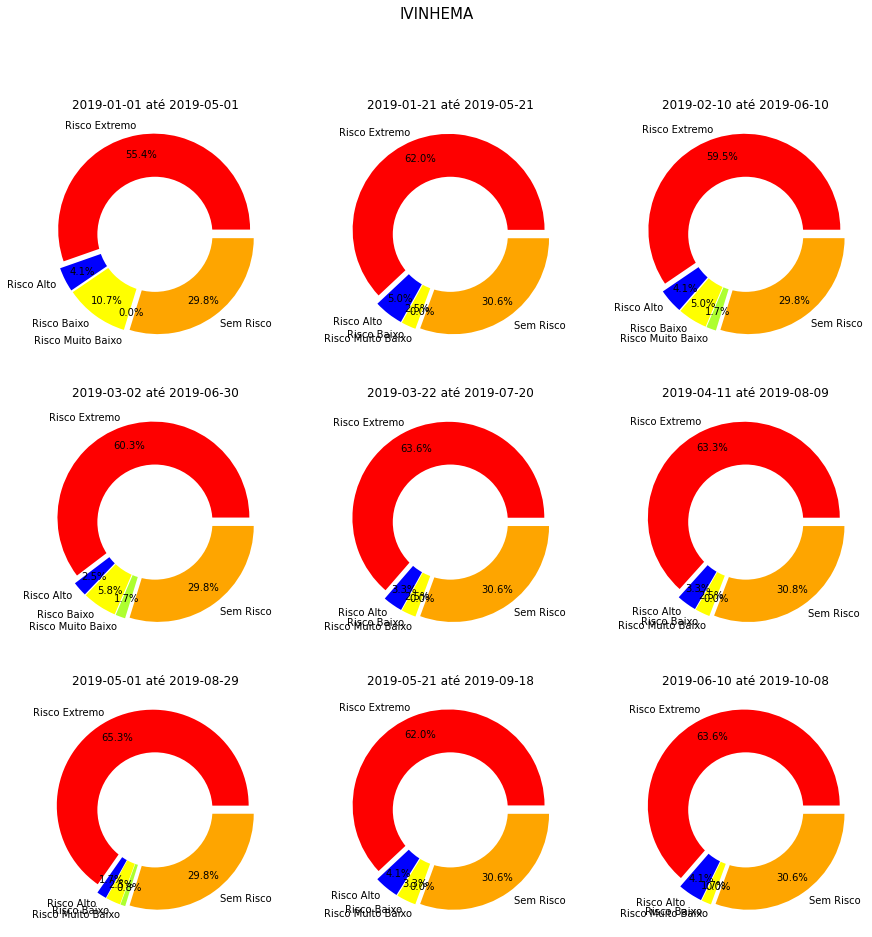

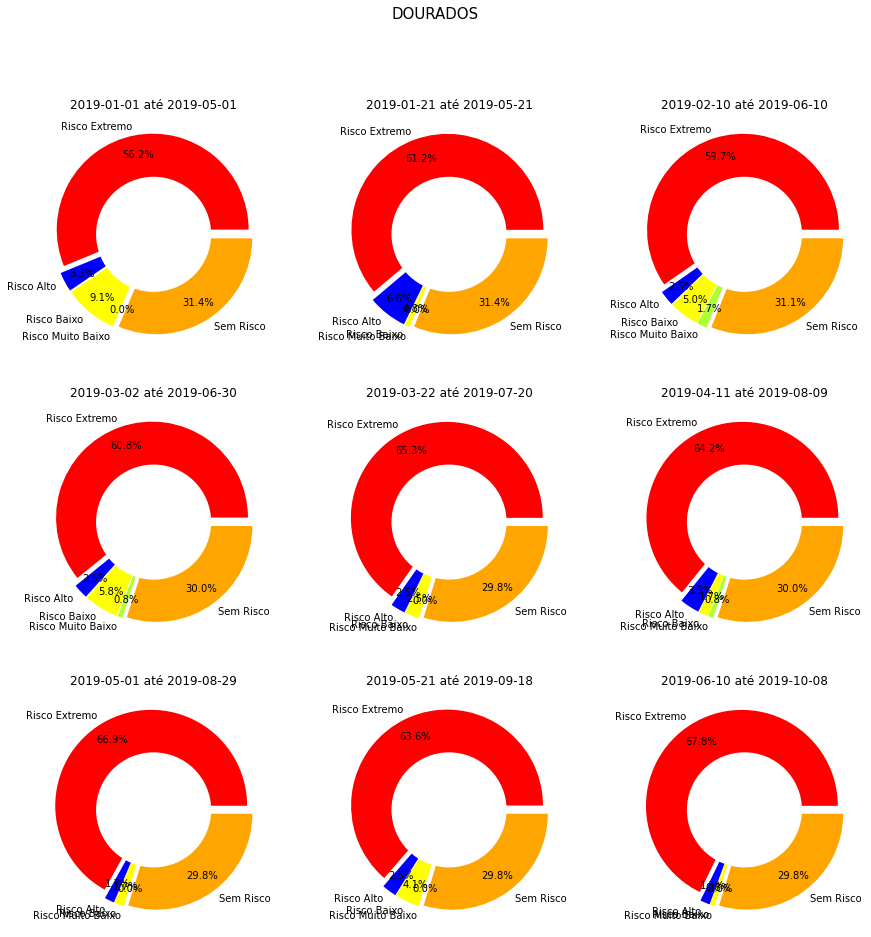

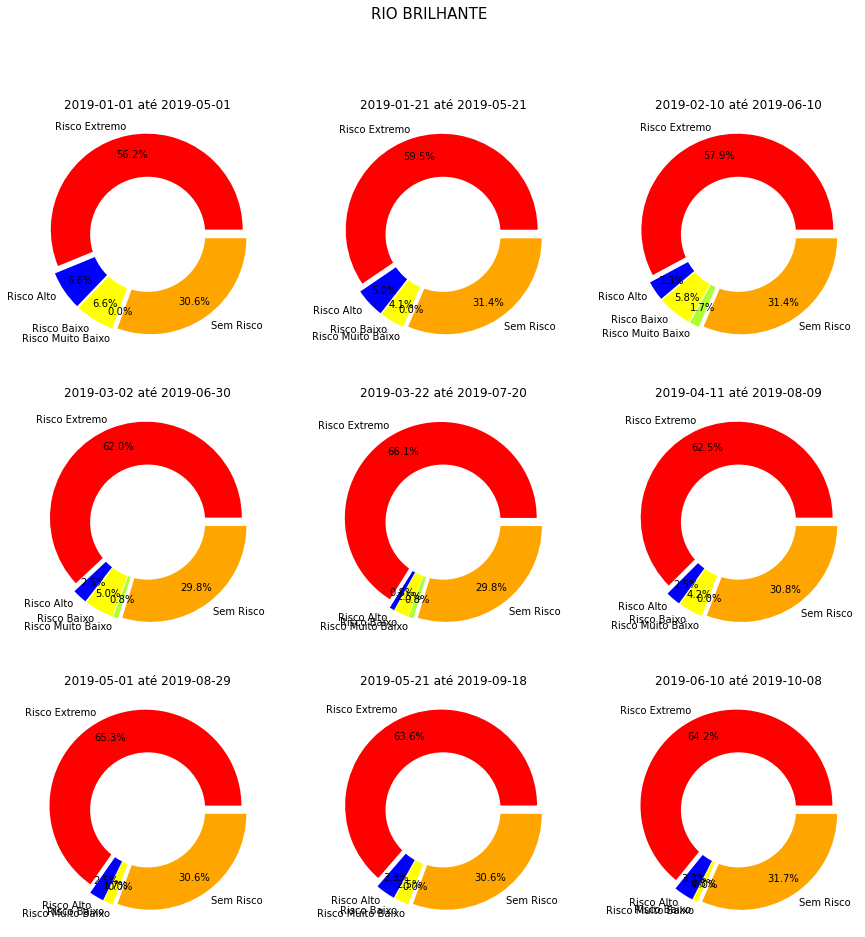

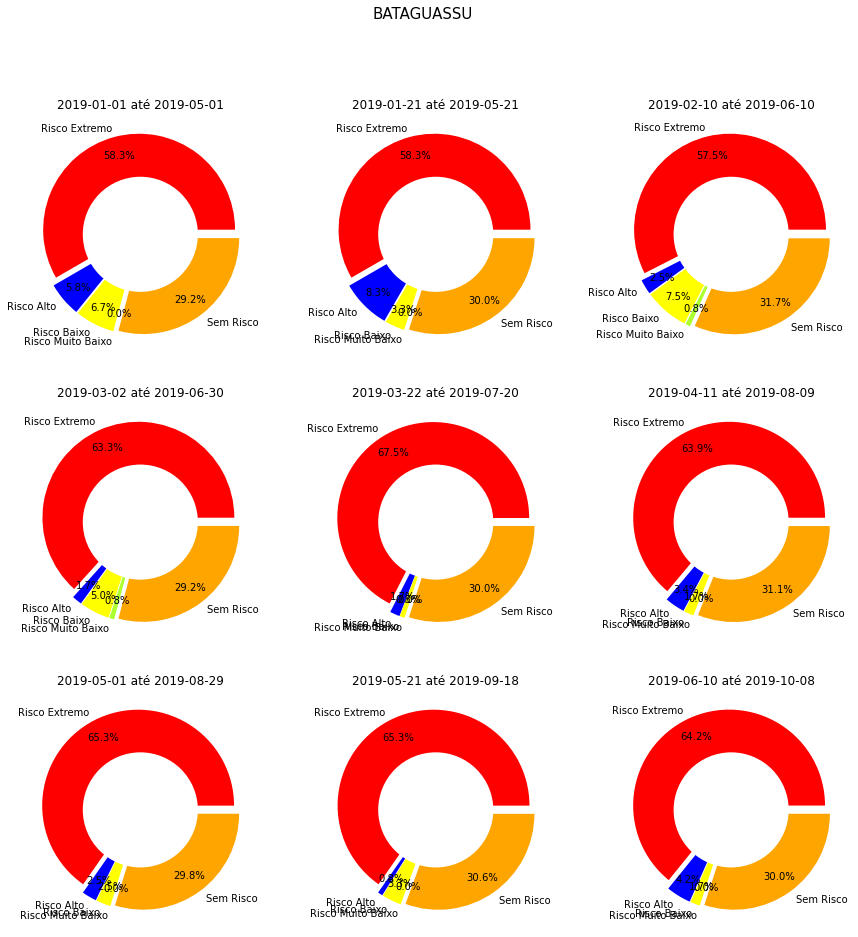

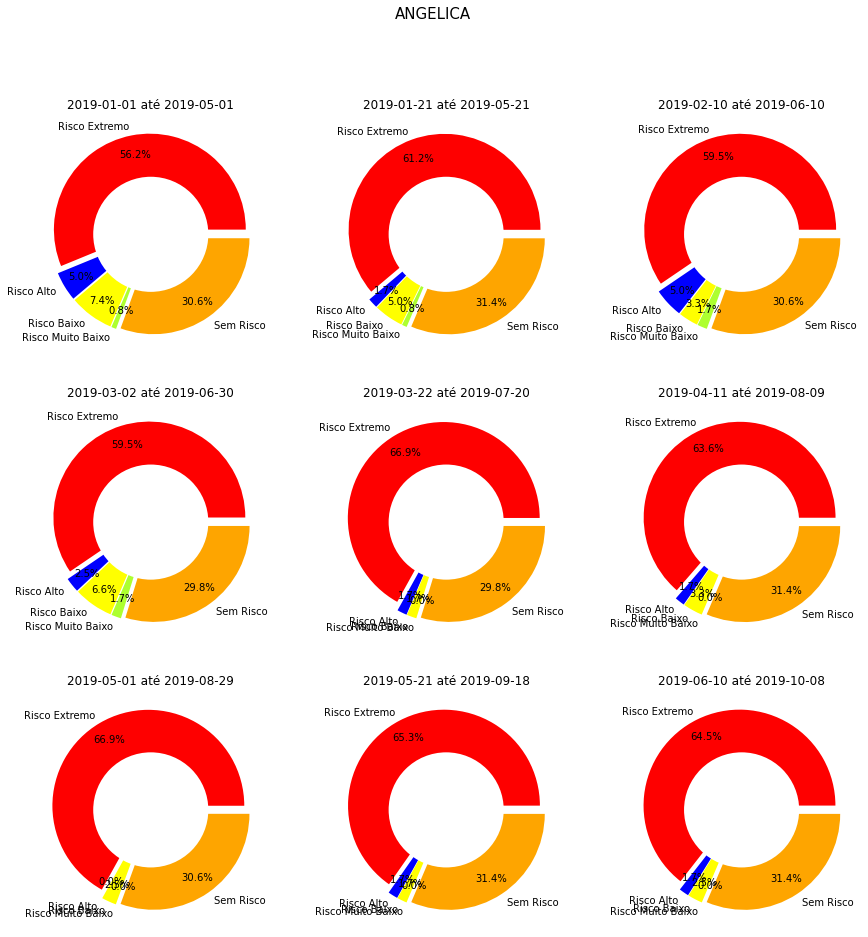

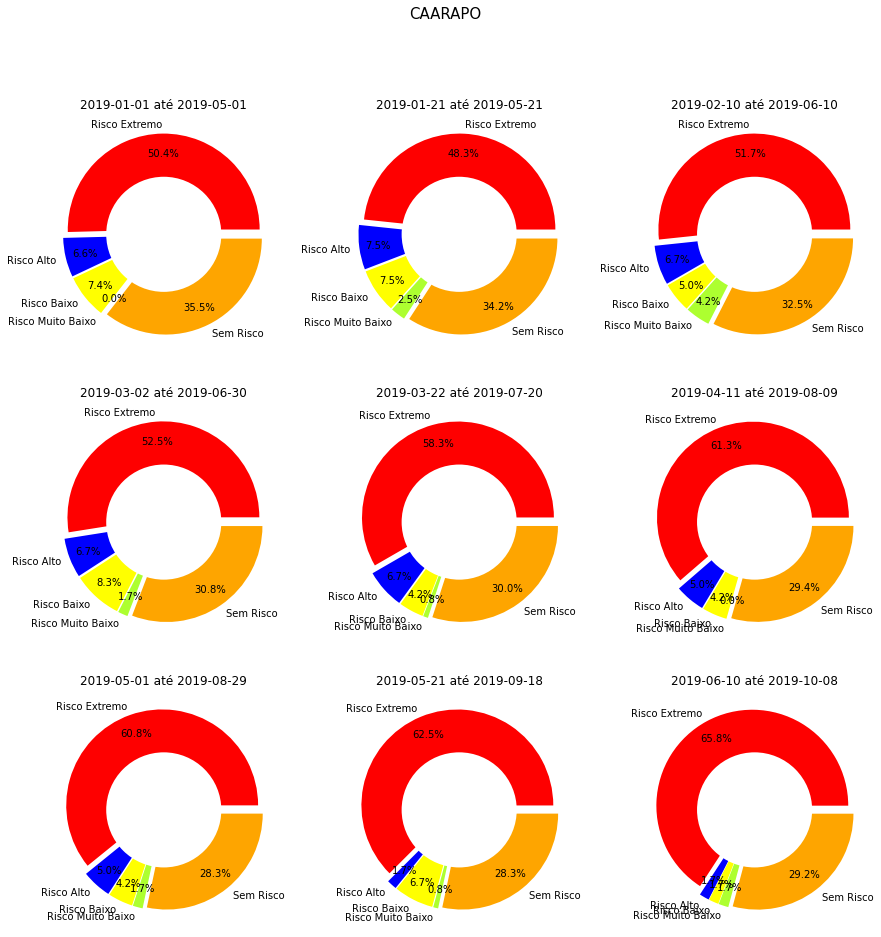

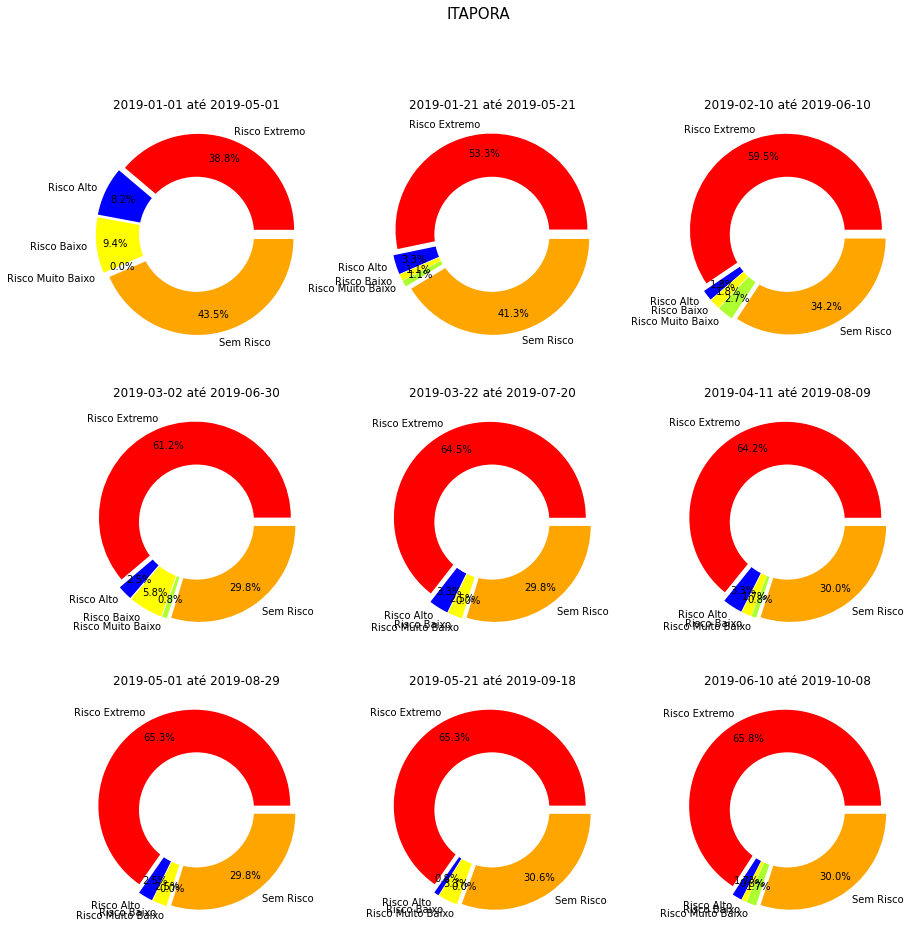

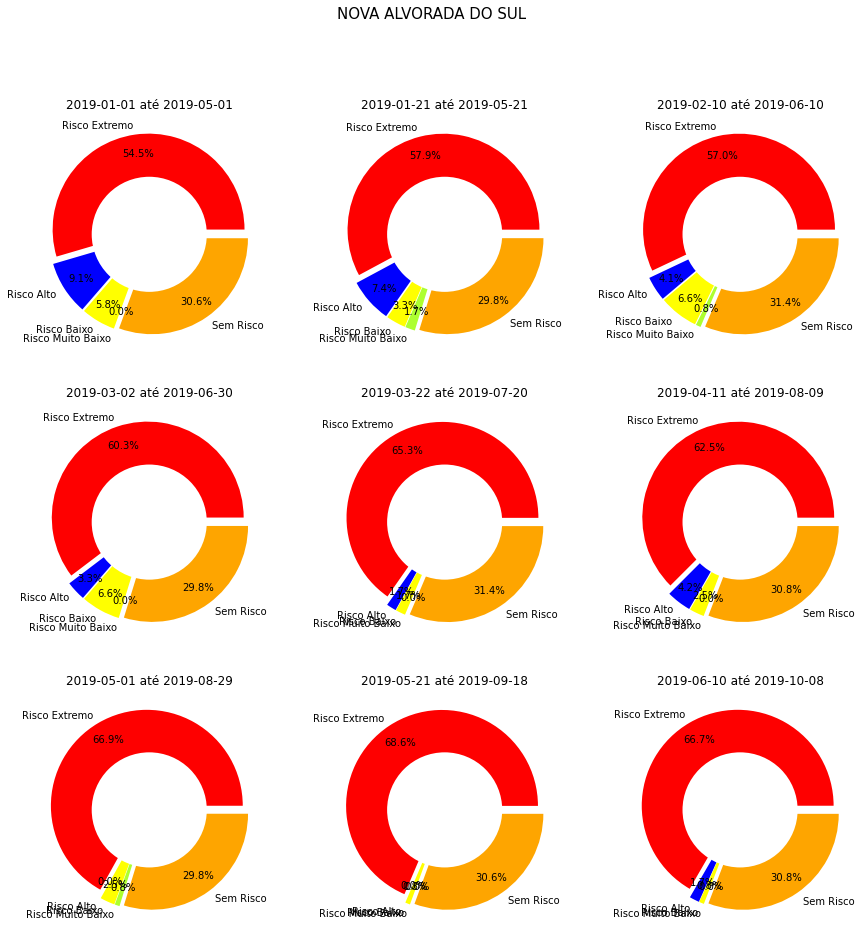

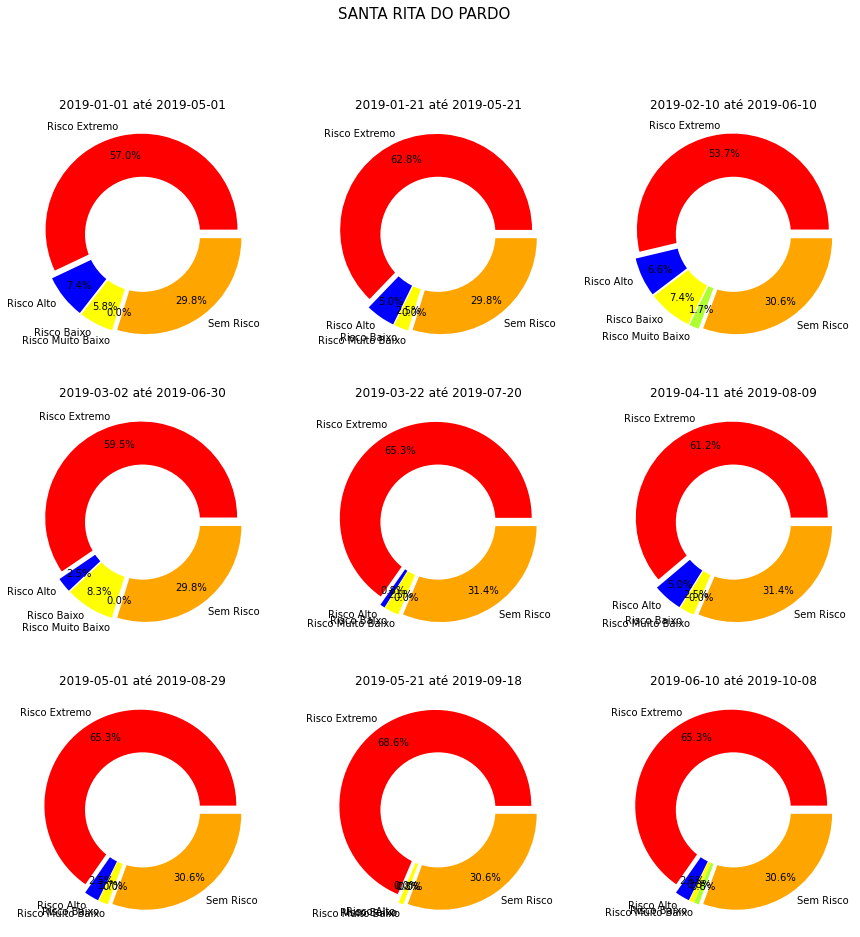

In [104]:
colors = ['#fe0000', '#0000fe', '#ffff00', '#adff30', '#fea500']
for j in range(9):
    fig, axs = plt.subplots(nrows=3, ncols=3)
    fig.set_size_inches(15, 15)
    for i, ax in enumerate(axs.reshape(-1)):
        ax.pie(isnas[j].iloc[:,i][:-1], labels=isnas[j].index[:-1], autopct='%1.1f%%', pctdistance=0.8, explode=[.05]*5, colors = colors)
        cc = plt.Circle((0, 0), 0.6, fc='white')
        ax.add_artist(cc)
        ax.title.set_text(isnas[0].columns[i])
    periodo = isnas[j].name
    fig.suptitle(periodo, fontsize=15)
    fig.savefig(f'datasets/isnas/{periodo}.png')

In [22]:
isnas[0].index

Index(['Risco Extremo', 'Risco Alto', 'Risco Baixo', 'Risco Muito Baixo',
       'Sem Risco', 'Erro'],
      dtype='object')